In [42]:
!pip install hdbscan umap-learn sentence-transformers openpyxl

import pandas as pd
import numpy as np
import hdbscan
import umap
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


📊 **Load & Embed Sector Data**

Load all required Excel datasets and compute SBERT embeddings for normalized sector descriptions.


In [43]:
pe_df = pd.read_excel("../newdata/Cleaned_PE.xlsx")
company_df = pd.read_excel("../newdata/outputcheckcombined.xlsx")
transactions_df = pd.read_excel("../newdata/PE_Transactions.xlsx")

sbert = SentenceTransformer('all-MiniLM-L6-v2')

# Normalize & embed sectors
company_df['normalized_sectors'] = company_df['1º_characterization'].fillna('').str.lower()
pe_df['normalized_sectors'] = pe_df['Sectors'].fillna('').str.lower()

company_df['sector_embeddings'] = company_df['normalized_sectors'].apply(lambda x: sbert.encode(x))
pe_df['sector_embeddings'] = pe_df['normalized_sectors'].apply(lambda x: sbert.encode(x))


🔗 **Cross Join & Feature Engineering**

Create all PE–company pairs and compute sector similarity, EBITDA compatibility, and Spanish market experience.


In [44]:
company_df['key'] = 1
pe_df['key'] = 1
pairs_df = company_df.merge(pe_df, on='key').drop('key', axis=1)

# --- Sector Similarity
pairs_df['sector_similarity_score'] = pairs_df.apply(
    lambda row: cosine_similarity(
        row['sector_embeddings_x'].reshape(1, -1),
        row['sector_embeddings_y'].reshape(1, -1)
    )[0][0], axis=1)

# --- EBITDA Compatibility
pairs_df['ebitda_in_range'] = pairs_df.apply(
    lambda row: row['ticket_ebitda_min'] <= row['ebitda_lya_m'] <= row['ticket_ebitda_max']
    if not pd.isnull(row['ebitda_lya_m']) else False, axis=1)

# --- PE experience in Spain
pairs_df['total_spanish_companies'] = pairs_df['Total Spanish Companies'].fillna(0)


⚙️ **Normalize & Cluster with HDBSCAN**

Standardize the features and cluster using HDBSCAN for unsupervised grouping of PE–company pairs.


In [45]:
X_features = pairs_df[['sector_similarity_score', 'ebitda_in_range', 'total_spanish_companies']]
X_features['ebitda_in_range'] = X_features['ebitda_in_range'].astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=8,
    min_samples=5,
    metric='euclidean',
    prediction_data=True,
    cluster_selection_method='eom'
)
pairs_df['cluster'] = clusterer.fit_predict(X_scaled)


C:\Users\Samir\AppData\Local\Temp\ipykernel_23704\3076420684.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_features['ebitda_in_range'] = X_features['ebitda_in_range'].astype(int)
c:\Users\Samir\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Samir\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


🌈 **UMAP Visualization**

Visualize HDBSCAN clusters in 2D space using UMAP dimensionality reduction.


c:\Users\Samir\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Samir\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
c:\Users\Samir\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


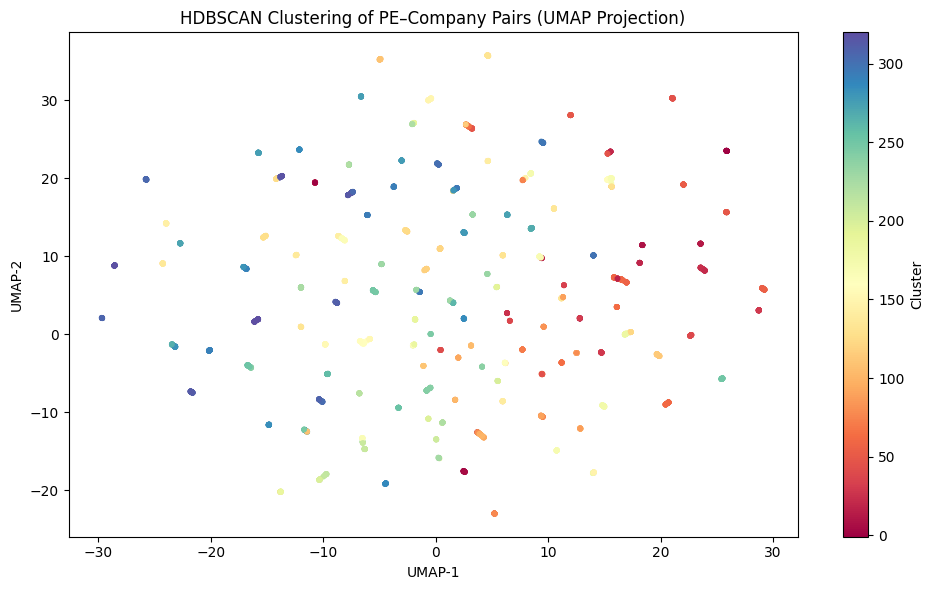

In [46]:
import umap.umap_ as umap

SAMPLE_SIZE = 3000
if X_scaled.shape[0] > SAMPLE_SIZE:
    sample_idx = np.random.choice(X_scaled.shape[0], SAMPLE_SIZE, replace=False)
    X_sample = X_scaled[sample_idx]
    cluster_sample = pairs_df.iloc[sample_idx]['cluster']
else:
    X_sample = X_scaled
    cluster_sample = pairs_df['cluster']

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_sample)

plt.figure(figsize=(10, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_sample, cmap='Spectral', s=10)
plt.colorbar(label='Cluster')
plt.title('HDBSCAN Clustering of PE–Company Pairs (UMAP Projection)')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.tight_layout()
plt.show()


📈 **Cluster Insights & Silhouette Score**

Assess clustering results using cluster count and silhouette score (on a sample).


In [47]:
import numpy as np

n_clusters = len(np.unique(pairs_df['cluster'])) - (1 if -1 in pairs_df['cluster'].values else 0)
print(f"Number of clusters (excluding noise): {n_clusters}")

cluster_summary = pairs_df.groupby('cluster')['PE'].apply(lambda x: x.value_counts().head(1))
print(cluster_summary)



Number of clusters (excluding noise): 321
cluster                                    
-1       Magnum Capital                           3
 0       Suma Capital                           364
 1       Suma Capital                          1525
 2       Alia Capital Partners                  364
 3       Kaizaharra Corporación Empresarial     364
                                               ... 
 316     Amundi Private Equity Funds SA        1522
 317     Astorg Partners SA                    1522
 318     Inspirit Capital                      1522
 319     AE Industrial Partners LP             1522
 320     Rhone Group LLC                       1522
Name: PE, Length: 322, dtype: int64


🎯 **Match Ratio Analysis by Cluster**

Evaluate how many known PE–company matches fall into each cluster to assess cluster relevance.


In [48]:
from sklearn.utils import resample
from sklearn.metrics import silhouette_score

X_sampled, y_sampled = resample(X_scaled, pairs_df['cluster'], n_samples=2000, random_state=42)
sil_score = silhouette_score(X_sampled, y_sampled)
print(f"Silhouette Score (sampled): {sil_score:.3f}")


Silhouette Score (sampled): 0.978


In [49]:
# Lowercased name pairs for matching
pairs_df['company_name_clean'] = pairs_df['company_name'].str.lower().str.strip()
pairs_df['pe_clean'] = pairs_df['PE'].str.lower().str.strip()
transactions_df['Target_clean'] = transactions_df['Target'].str.lower().str.strip()
transactions_df['PE_clean'] = transactions_df['PE'].str.lower().str.strip()

known_matches = set(zip(transactions_df['Target_clean'], transactions_df['PE_clean']))

pairs_df['target'] = pairs_df.apply(
    lambda row: 1 if (row['company_name_clean'], row['pe_clean']) in known_matches else 0,
    axis=1
)

cluster_target_summary = pairs_df.groupby(['cluster', 'target']).size().unstack(fill_value=0)
cluster_target_summary['match_ratio'] = cluster_target_summary[1] / (cluster_target_summary[0] + cluster_target_summary[1])
cluster_target_summary = cluster_target_summary.sort_values('match_ratio', ascending=False)

# Top clusters with at least 2 known matches
top_clusters = cluster_target_summary[cluster_target_summary[1] >= 2]
print(top_clusters.head(10))


target      0  1  match_ratio
cluster                      
20       1520  3     0.001970
44       1520  3     0.001970
151      1520  2     0.001314
49       1522  2     0.001312


In [50]:
import pickle

# Save HDBSCAN model and scaler
with open("hdbscan_model.pkl", "wb") as f:
    pickle.dump(clusterer, f)

with open("hdbscan_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Save features used
with open("hdbscan_features.pkl", "wb") as f:
    pickle.dump(['sector_similarity_score', 'ebitda_in_range', 'total_spanish_companies'], f)


## Cosine Similarity-Based PE Ranking


🤖 **Cosine Similarity Matching & Precision@5**

Score all PE–company pairs using cosine similarity of scaled features and compute Precision@5.


In [38]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict

# --- Build feature matrix for cosine comparison ---
cosine_features = pairs_df[['sector_similarity_score', 'ebitda_in_range', 'total_spanish_companies']].copy()
cosine_features['ebitda_in_range'] = cosine_features['ebitda_in_range'].astype(int)

# Normalize feature values (0 to 1)
scaler = MinMaxScaler()
cosine_features_scaled = scaler.fit_transform(cosine_features)

# Reattach to DataFrame
pairs_df[['f_sector_sim', 'f_ebitda', 'f_spanish_exp']] = cosine_features_scaled

# Group by company and compute cosine similarity for each PE
precision_at_k = defaultdict(list)
known_matches = set(
    zip(transactions_df['Target'].str.lower().str.strip(), transactions_df['PE'].str.lower().str.strip())
)

for company_name, group in pairs_df.groupby('company_name'):
    company_vector = group[['f_sector_sim', 'f_ebitda', 'f_spanish_exp']].iloc[0].values.reshape(1, -1)
    pe_vectors = group[['f_sector_sim', 'f_ebitda', 'f_spanish_exp']].values

    # Compute cosine similarities between company and each PE
    similarities = cosine_similarity(company_vector, pe_vectors)[0]
    group['cosine_score'] = similarities

    top_k = group.sort_values('cosine_score', ascending=False).head(5)
    
    company_name_clean = company_name.lower().strip()
    top_k_pe_clean = top_k['PE'].str.lower().str.strip()

    # Check if any of the top-5 PEs are known matches
    is_match = any((company_name_clean, pe) in known_matches for pe in top_k_pe_clean)
    precision_at_k[5].append(int(is_match))

# --- Final Precision@5 ---
p_at_5 = sum(precision_at_k[5]) / len(precision_at_k[5])
print(f"Precision@5 (multi-feature cosine similarity): {p_at_5:.4f}")


Precision@5 (multi-feature cosine similarity): 0.0012


💾 **Save Cosine Similarity Tools**

Save the MinMaxScaler and features used in cosine-based ranking.


In [40]:
# Save MinMaxScaler used for cosine similarity
with open("cosine_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Save feature names used for cosine
with open("cosine_features.pkl", "wb") as f:
    pickle.dump(['f_sector_sim', 'f_ebitda', 'f_spanish_exp'], f)
